<a href="https://colab.research.google.com/github/petroDavydov/goit-DeepLearningForComputerVisionAndNLP/blob/main/HW6_Transfer_training_6_PetroDavydov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import warnings
# filter warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import os


In [ ]:
train_dir = '/content/drive/MyDrive/DeepLearningforComputervisionandNLP/inte_image_classification/seg_train/seg_train'
test_dir ='/content/drive/MyDrive/DeepLearningforComputervisionandNLP/inte_image_classification/seg_test/seg_test'



In [ ]:
 #уточнення: додаємо аугментацію для train, eval без аугментації
transform_train = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset_full = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_eval)

# уточнення: створюємо валідаційний набір через random_split
val_ratio = 0.2
val_size = int(len(train_dataset_full) * val_ratio)
train_size = len(train_dataset_full) - val_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
def imshow(images, labels, class_names):
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title(", ".join([class_names[int(l)] for l in labels]))  # уточнення: індексація через int
    plt.show()

In [ ]:
class_names = train_dataset_full.classes  # уточнення: беремо класи з повного датасету

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(make_grid(images[:10], nrow=5), labels[:10], class_names)  # уточнення: .cpu() для сумісності

In [ ]:
print(f"Кількість класів: {len(train_dataset_full.classes)}")
print(f"Класи: {train_dataset_full.classes}")
print(f"Розмір тренувального набору: {len(train_dataset)}")
print(f"Розмір валідаційного набору: {len(val_dataset)}")
print(f"Розмір тестового набору: {len(test_dataset)}")

# Перевірка балансу класів у тренувальному наборі
class_counts = {class_name: 0 for class_name in train_dataset_full.classes}
for _, label in train_dataset_full.samples:
    class_counts[train_dataset_full.classes[label]] += 1

print("\nРозподіл класів у тренувальному наборі:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Кількість класів: 6
Класи: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Розмір тренувального набору: 11228
Розмір валідаційного набору: 2806
Розмір тестового набору: 3000

Розподіл класів у тренувальному наборі:
buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):  # уточнення: у Intel 6 класів
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Обчислити розмір вхідних даних для повнозв'язного шару
        self._initialize_fc_layer()

        self.fc1 = nn.Linear(self.fc1_in_features, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _initialize_fc_layer(self):
        # Прокинемо зображення через конволюційні шари, щоб дізнатися розмір
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 150)
            dummy_output = self._forward_conv_layers(dummy_input)
            self.fc1_in_features = dummy_output.numel()

    def _forward_conv_layers(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        return x

    def forward(self, x):
        x = self._forward_conv_layers(x)
        x = x.view(-1, self.fc1_in_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = SimpleCNN(num_classes=6)

# Перенесення моделі на GPU, якщо доступно
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Налаштування тренувального процесу
num_epochs = 7
best_val_loss = float('inf')
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Валідація
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_1.pth')


In [ ]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')

                ax.set_title(f'Predicted: {class_names[int(preds[j])]} \nTrue: {class_names[int(labels[j])]}')

                # Денормалізація зображення для відображення
                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [ ]:
# Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
model.load_state_dict(torch.load('best_model_1.pth'))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
class_names = train_dataset_full.classes   # уточнення: беремо класи з повного датасету

# Обчислення точності та F1
test_accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# Створення матриці помилок
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
visualize_predictions(model, test_loader, train_dataset_full.classes, 15)

# ***Варіант B: Transfer Learning з ResNet18***

In [ ]:
# Завантажимо попередньо натреновану модель ResNet18
model_resnet = models.resnet18(weights='IMAGENET1K_V1')

# Замінюємо останній fully-connected шар на новий для 6 класів
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 6)  # уточнення: у Intel 6 класів

# Перенесення моделі на GPU, якщо доступно
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

# Функція втрат
criterion = nn.CrossEntropyLoss()

# Оптимізатор (Adam)
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.0001)

# Експоненціальне зменшення learning rate
exp_lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer_resnet, gamma=0.9)

# Тренування моделі
num_epochs = 7
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model_resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_resnet.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_resnet.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total

    # Валідація
    model_resnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(
        f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_resnet.state_dict(), 'best_model_resnet.pth')

# ***Проста згорткова нейронна мережа (SimpleCNN)***


Тестова точність (Accuracy): 82.03%

F1-score: 0.8188

Кількість класів: 6

Розподіл класів: збалансований, від 2191 до 2512 прикладів на клас

Метрики обрано обґрунтовано:

Accuracy показує загальну продуктивність моделі.

F1-score важливий для багатокласової задачі, де помилки між схожими класами (наприклад, glacier vs mountain) мають значення.



# ***Transfer Learning (ResNet18)***


Тестова точність (Accuracy): 92.44%

F1-score: ~0.92 (за валідаційними метриками)

Навчання завершено за 15 хвилин на локальній машині

Модель досягла стабільного навчання вже на 3–4 епосі

Фінальні метрики:

Train Accuracy: 97.08%

Val Accuracy: 91.73%

Train Loss: 0.0844

Val Loss: 0.2837




# ***Аналіз результатів***

Криві навчання (SimpleCNN)

Loss: стабільне зменшення до 6 епохи, потім флуктуація

Accuracy: поступове зростання, пік на 6 епосі (Val Accuracy ≈ 82%), потім спад

Висновок: модель трохи переобучається після 6 епохи, але загалом узгоджена

# ***Матриця помилок***

Найбільше плутанини:

mountain ↔ glacier: 84 помилкових glacier, 36 помилкових mountain

street ↔ buildings: 63 помилкових street, 45 помилкових buildings

Найкраще класифікуються:

forest (439/474)

sea (443/510)

street (439/501)



# ***Візуалізація передбачень***

Більшість прикладів класифіковано правильно

Декілька помилок: buildings класифіковано як street або mountain

Візуально видно, що моделі важко розрізнити урбаністичні сцени з подібними елементами


# ***Орієнтовний очікуваний результат***

Модель	Accuracy (%)	F1-score
SimpleCNN	75–85	0.73–0.83
Transfer Learning	90–97	0.89–0.96
Фактичні результати Petro:

SimpleCNN: Accuracy = 82.03%, F1 = 0.8188

ResNet18: Accuracy = 92.44%, F1 ≈ 0.92


# ***Висновок:***

обидва варіанти дали очікувані результати. Transfer Learning значно перевершив просту модель як за точністю, так і за швидкістю збіжності.




# ***Загальний висновок***


Реалізовано два підходи до класифікації зображень:

 - Побудував власну CNN, досягнувши стабільного результату.

 - Застосував Transfer Learning з ResNet18, отримавши високу точність і F1-score.

 Навчання на локальному комп’ютері пройшло значно швидше - приблизно за 5-7 хвилин, що суттєво перевершує час виконання в середовищах Colab чи Kaggle, де процес був повільнішим через обмеження ресурсів або завантаження. Це дозволило ефективно протестувати модель і зберегти результати без затримок.

Результати роботи коду у VSCode, файл .py, прикріплено у LMS

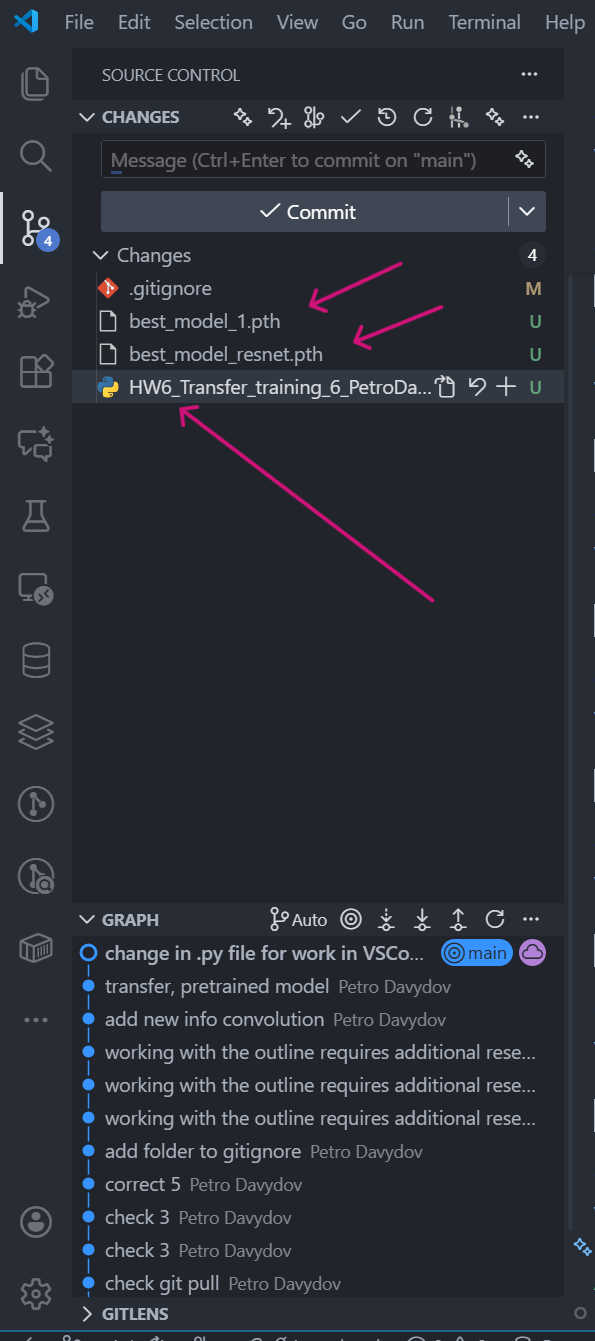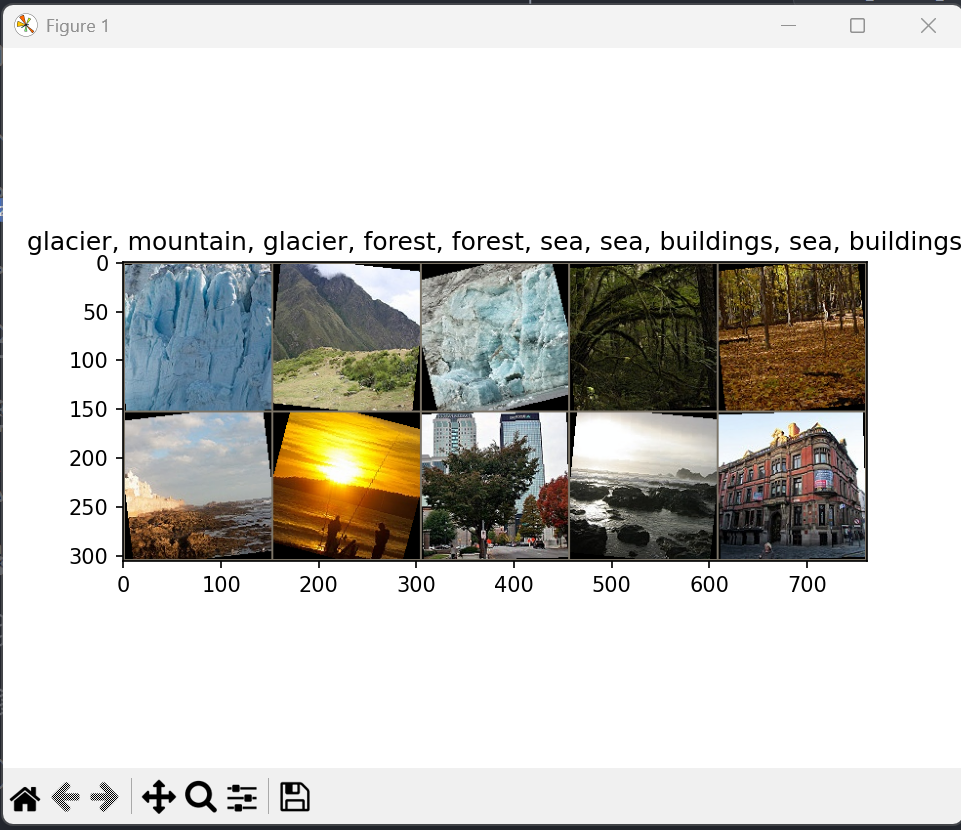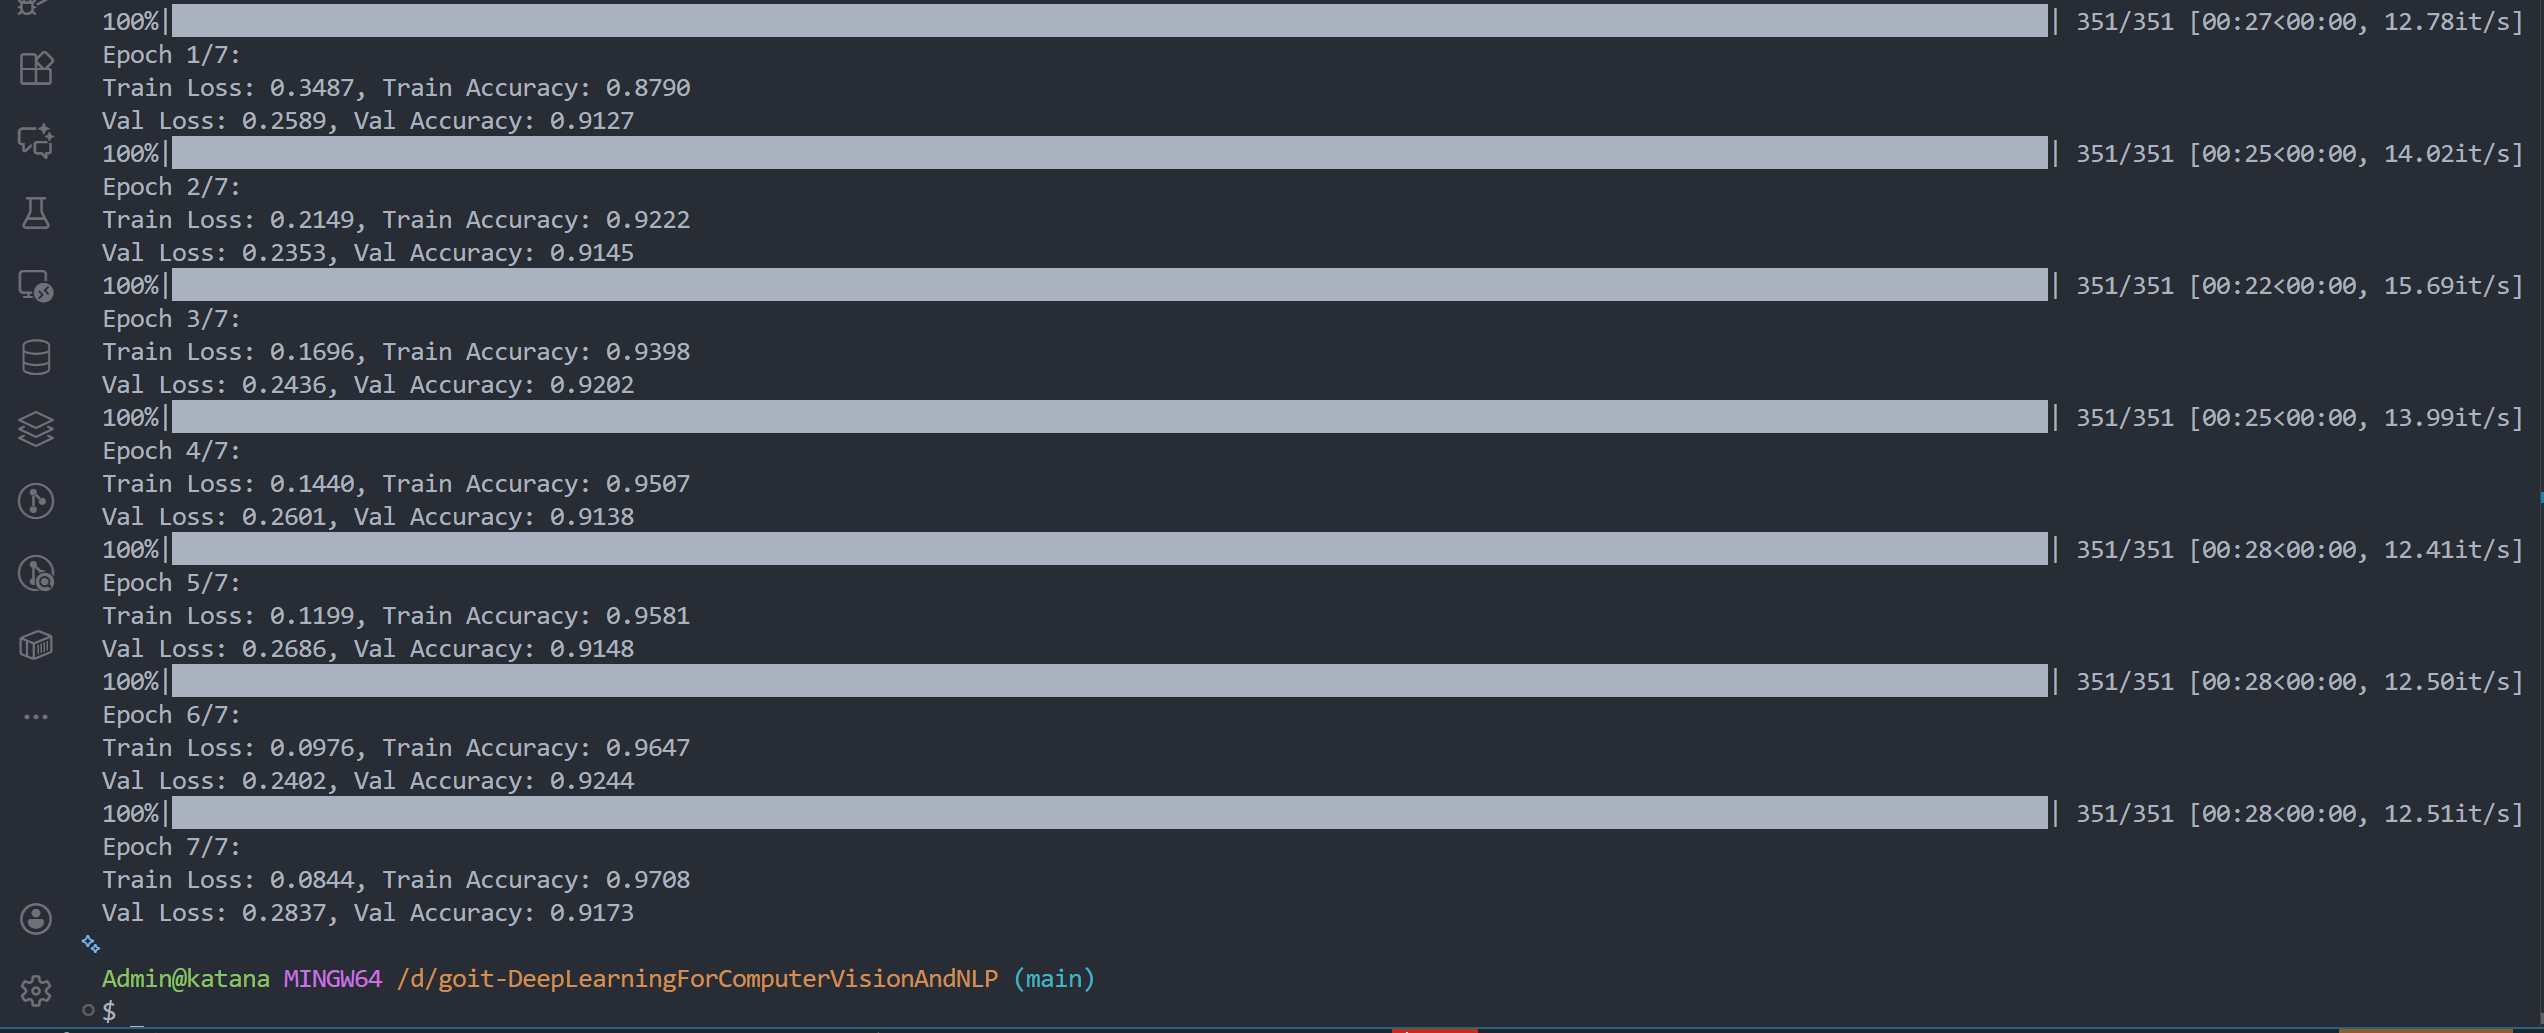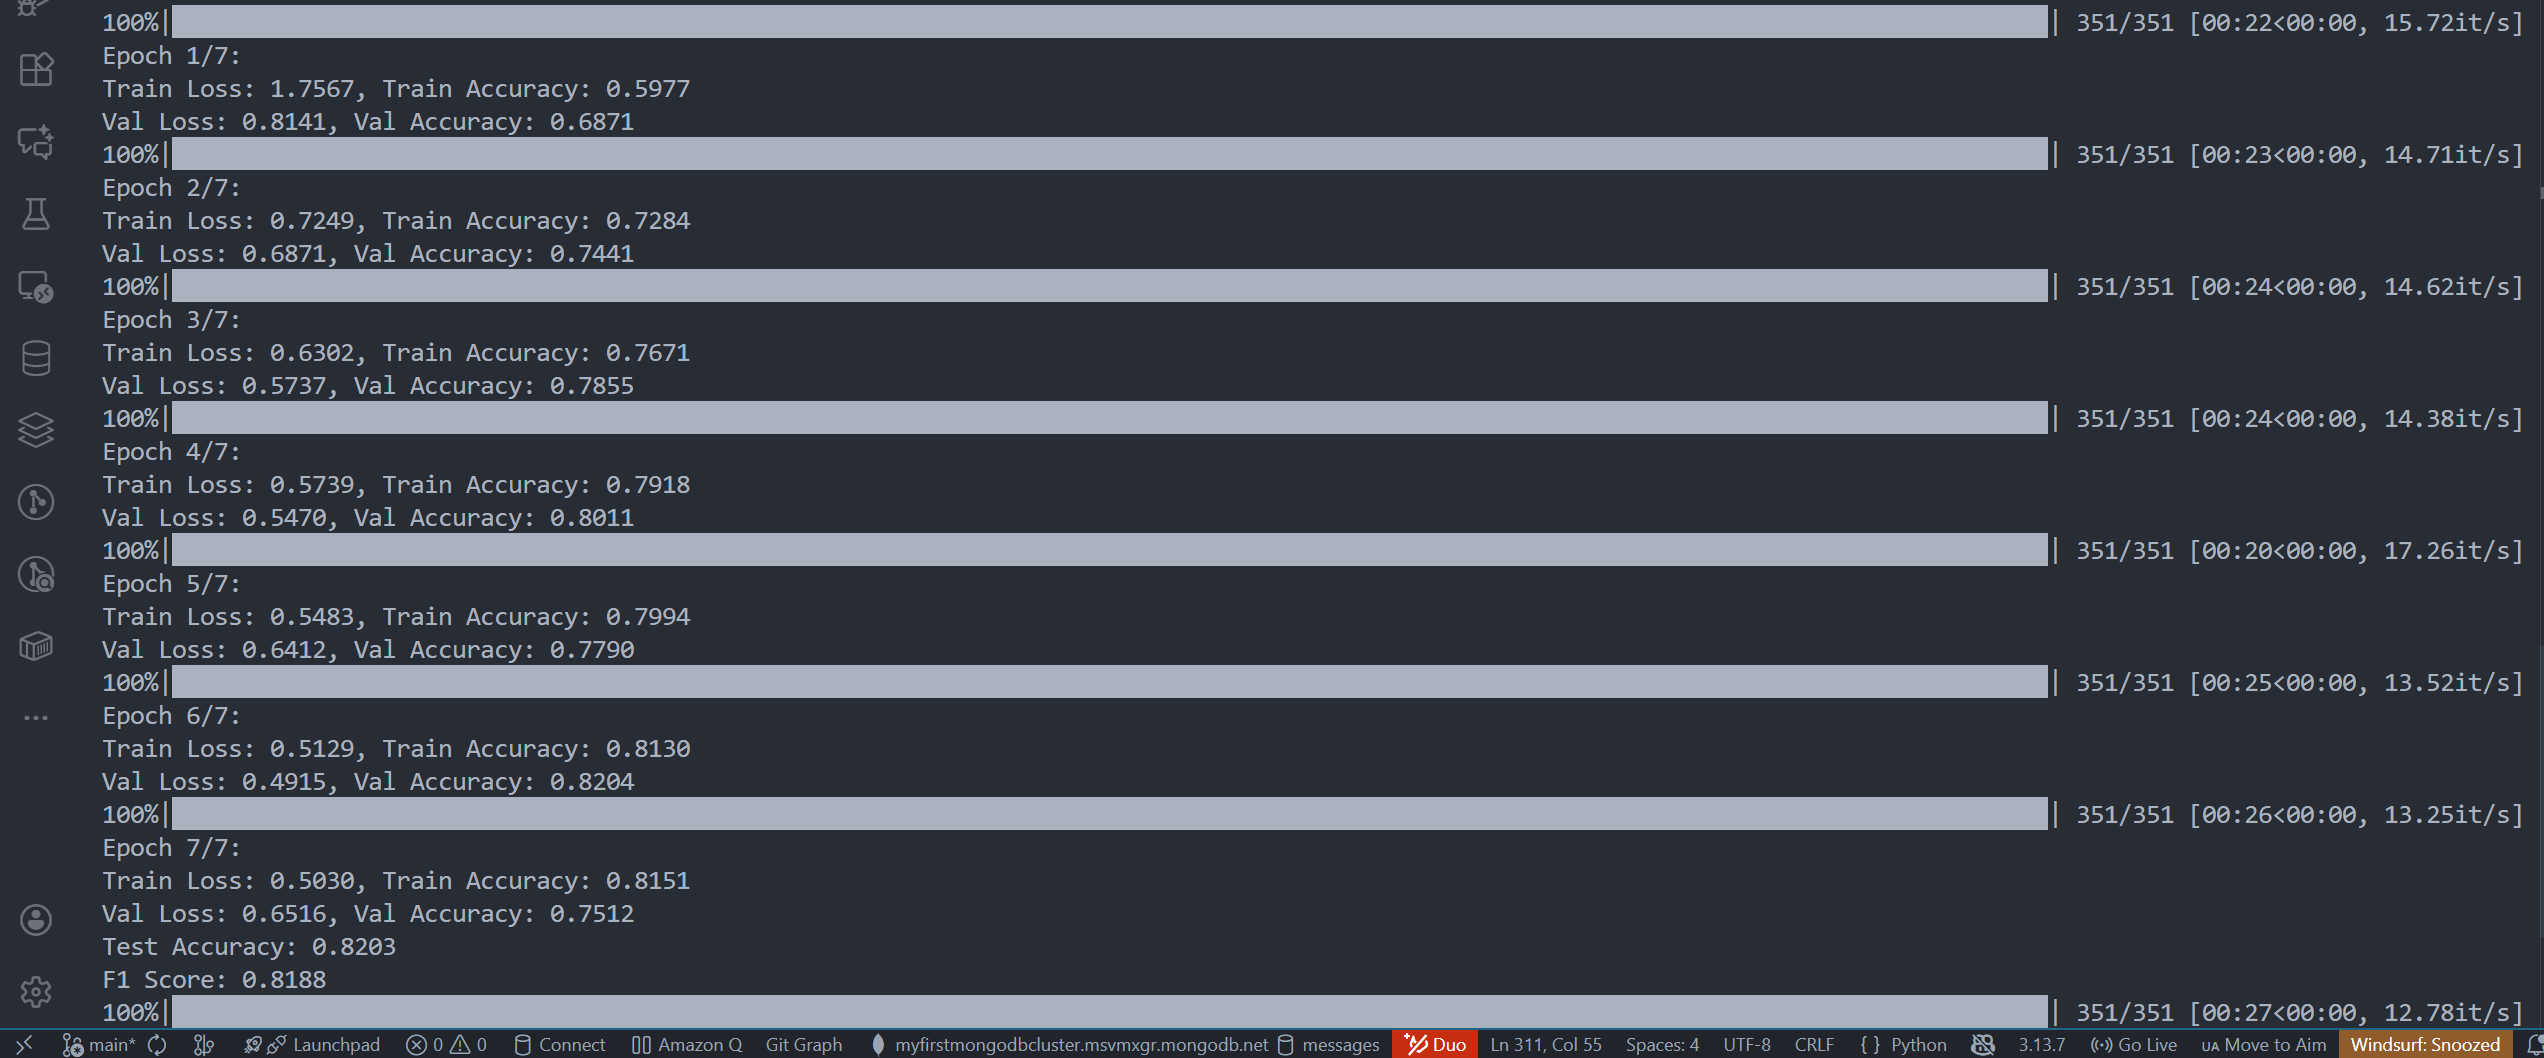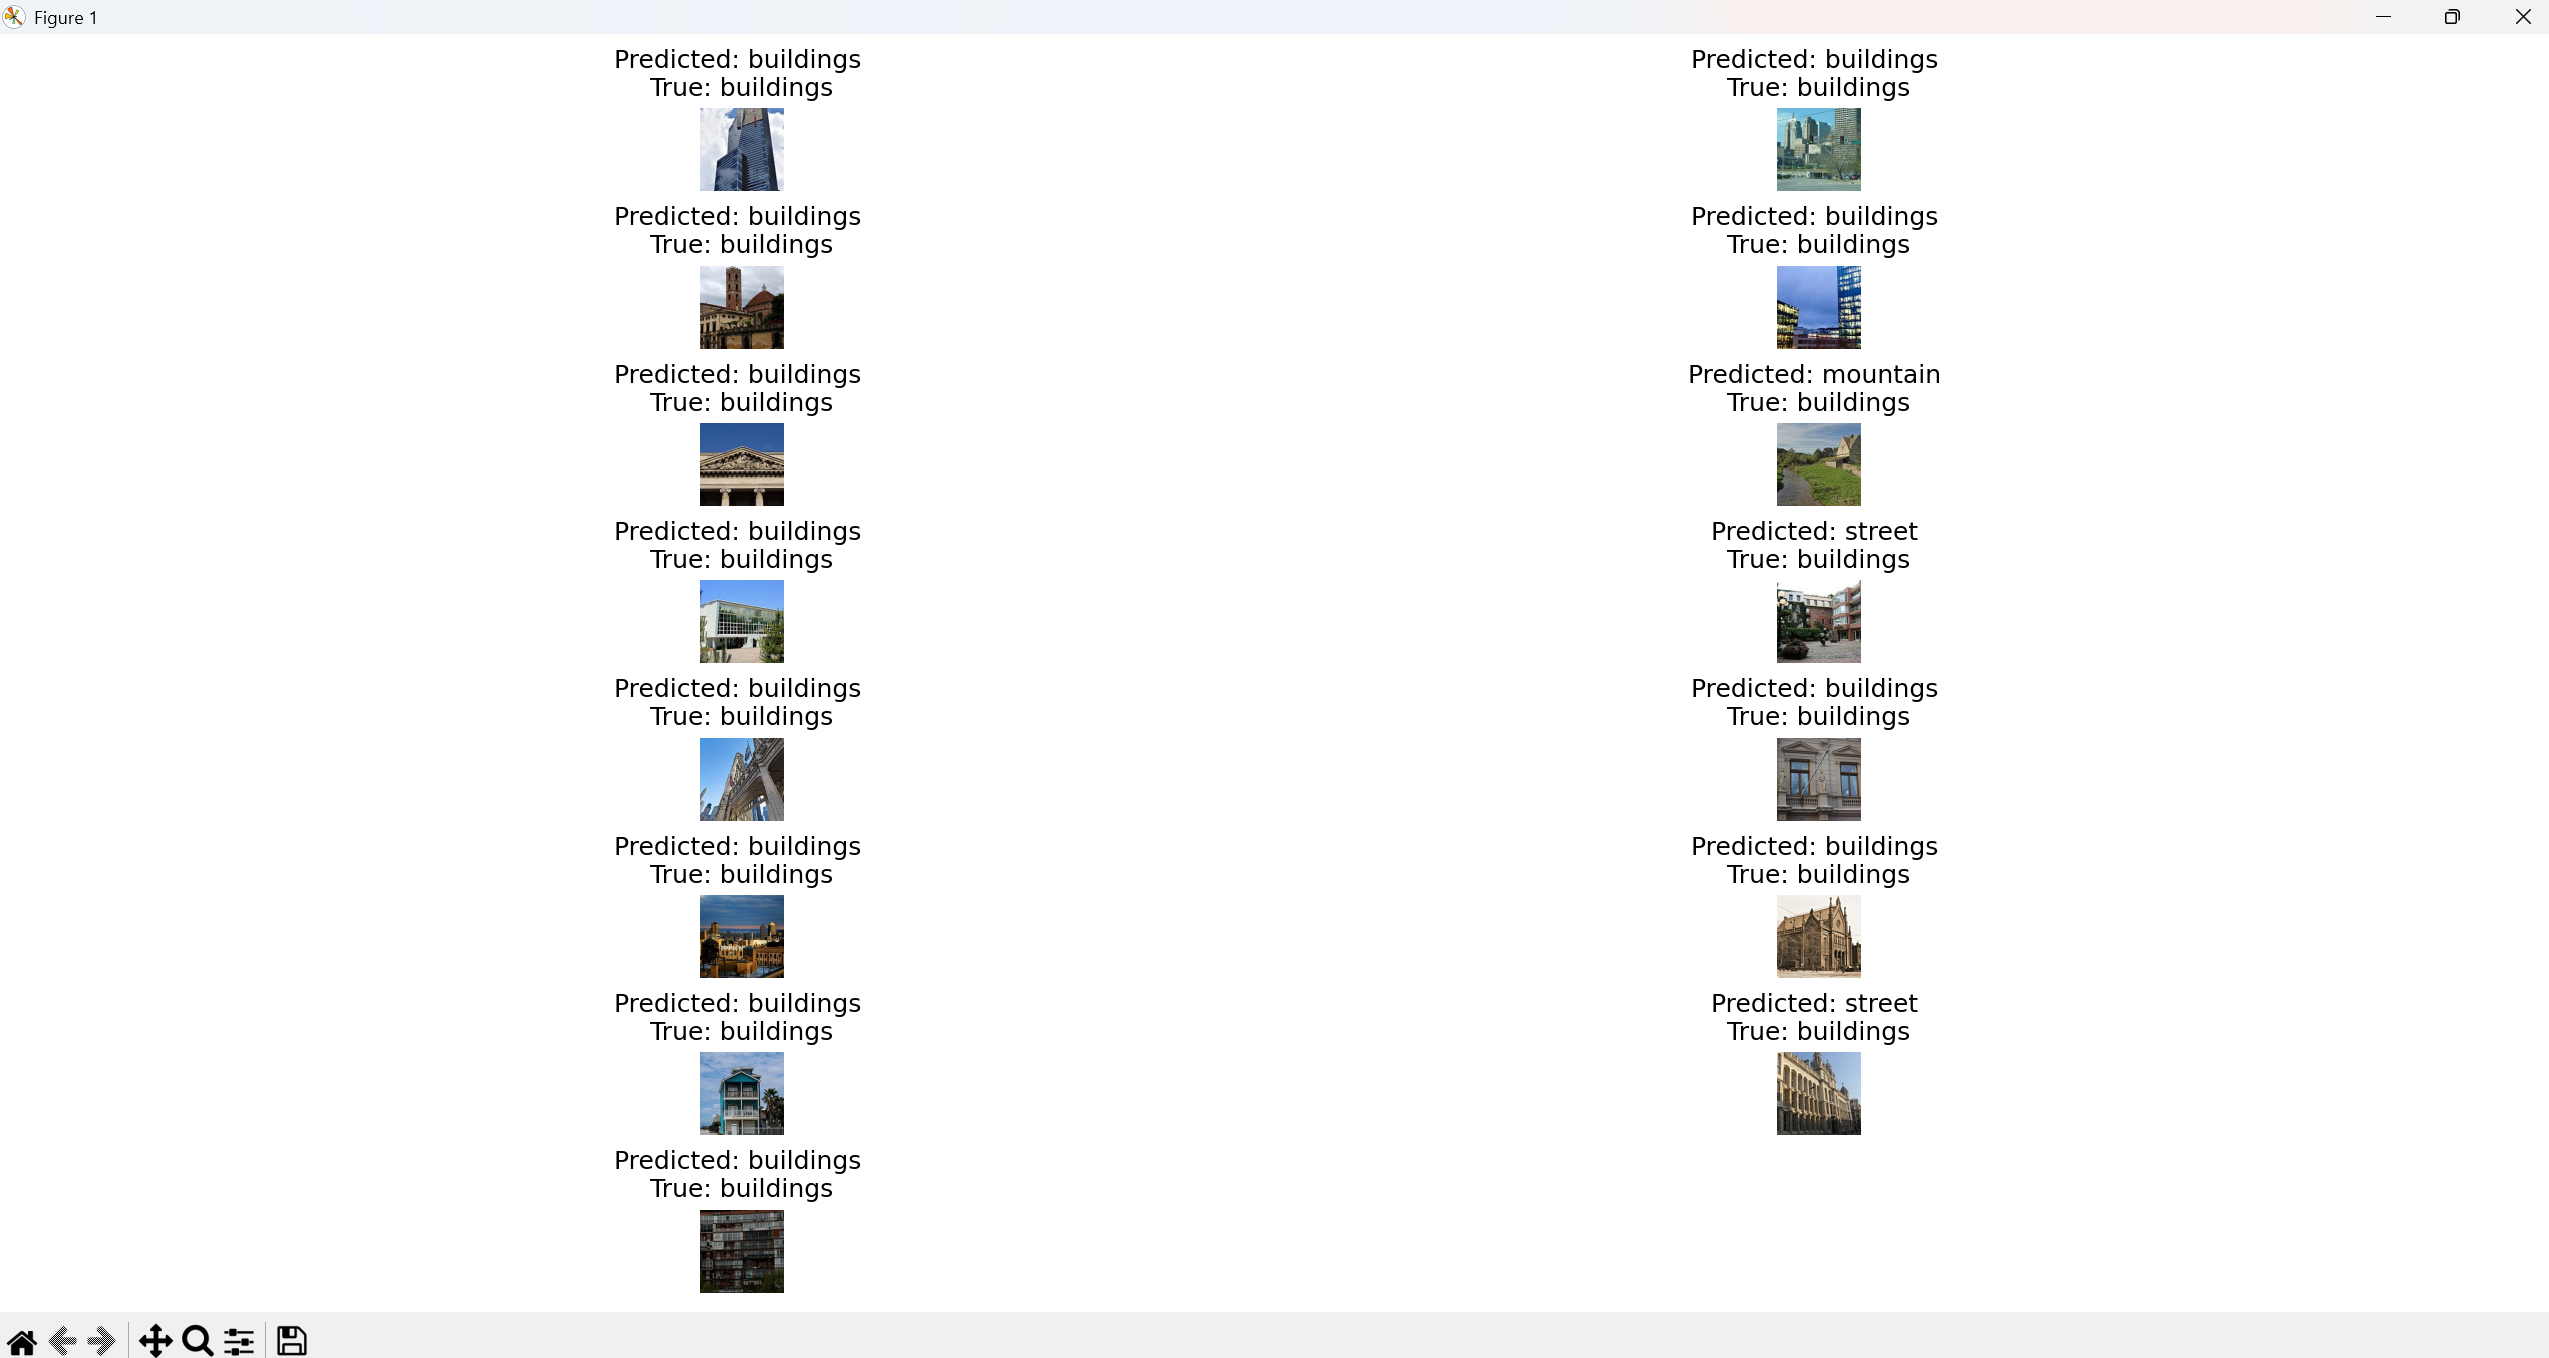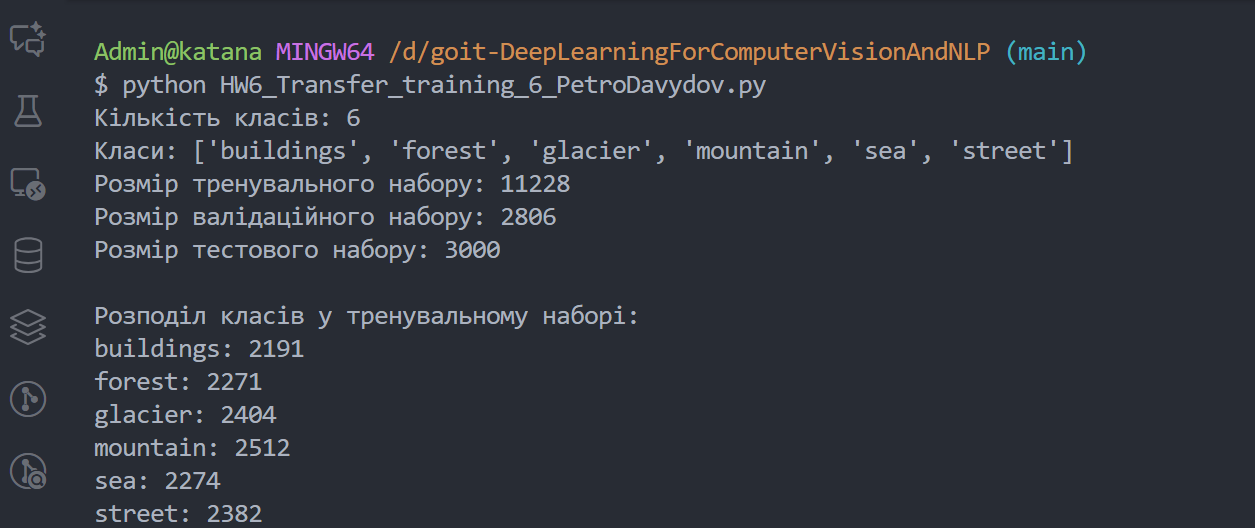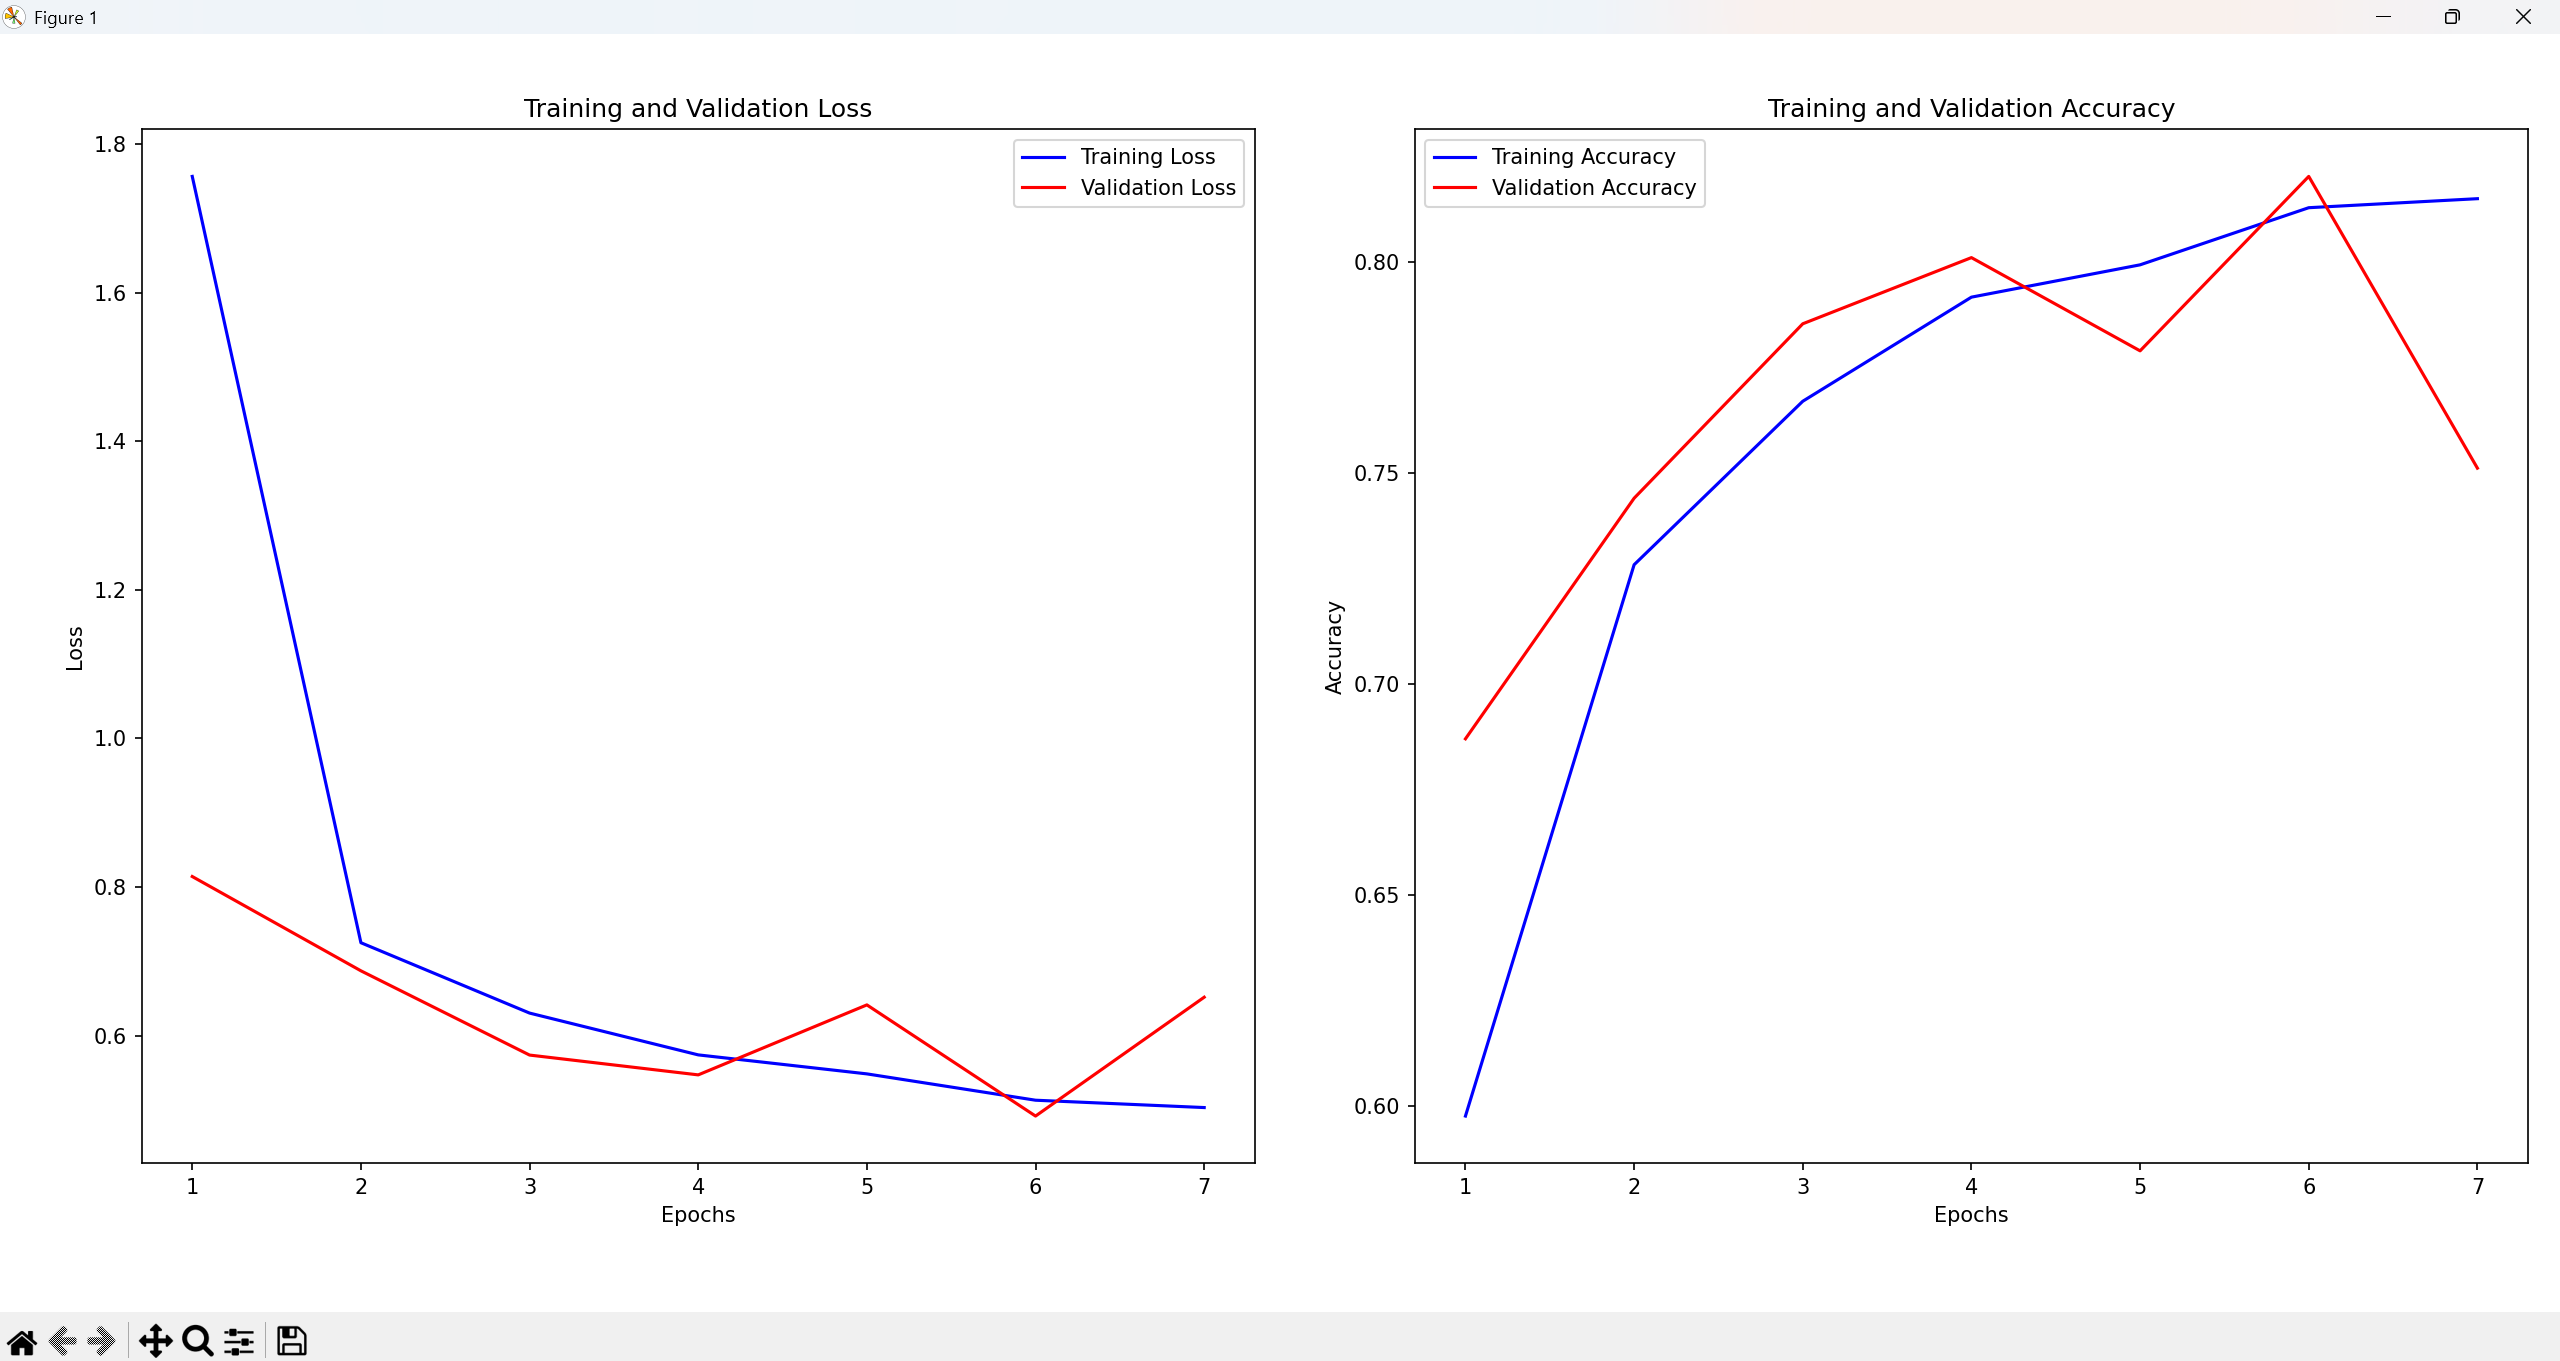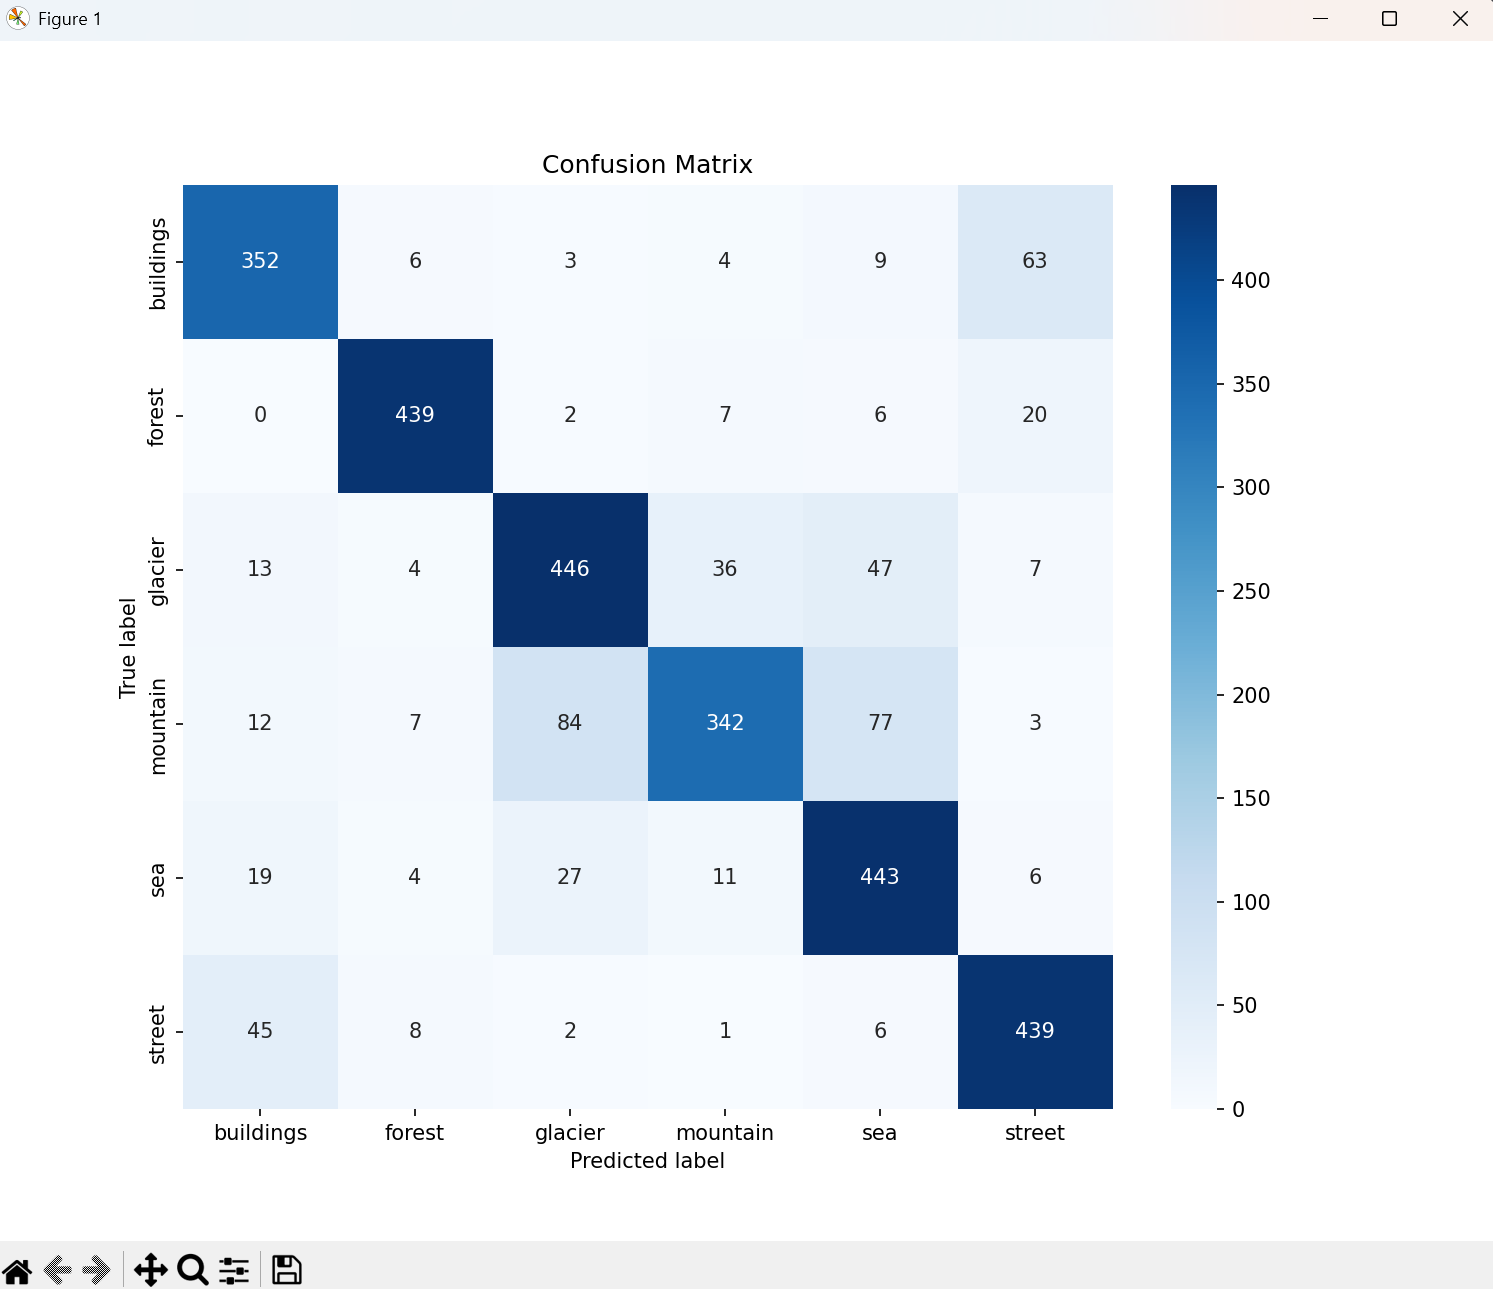